# _(Brunel & Hakim, 1999)_ Fast Global Oscillation

Implementation of the paper:

- Brunel, Nicolas, and Vincent Hakim. "Fast global oscillations in networks of integrate-and-fire neurons with low firing rates." Neural computation 11.7 (1999): 1621-1671.

Author: [Chaoming Wang](mailto:chao.brain@qq.com)

In [1]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')

In [2]:
Vr = 10.  # mV
theta = 20.  # mV
tau = 20.  # ms
delta = 2.  # ms
taurefr = 2.  # ms
duration = 100.  # ms
J = .1  # mV
muext = 25.  # mV
sigmaext = 1.  # mV
C = 1000
N = 5000
sparseness = float(C) / N

In [3]:
class LIF(bp.dyn.NeuGroup):
  def __init__(self, size, **kwargs):
    super(LIF, self).__init__(size, **kwargs)

    # variables
    self.V = bm.Variable(bm.ones(self.num) * Vr)
    self.t_last_spike = bm.Variable(-1e7 * bm.ones(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.refractory = bm.Variable(bm.zeros(self.num, dtype=bool))

    # integration functions
    fv = lambda V, t: (-V + muext) / tau
    gv = lambda V, t: sigmaext / bm.sqrt(tau)
    self.int_v = bp.sdeint(f=fv, g=gv)

  def update(self, _t, _dt):
    V = self.int_v(self.V, _t, dt=_dt)
    in_ref = (_t - self.t_last_spike) < taurefr
    V = bm.where(in_ref, self.V, V)
    spike = V >= theta
    self.spike.value = spike
    self.V.value = bm.where(spike, Vr, V)
    self.t_last_spike.value = bm.where(spike, _t, self.t_last_spike)
    self.refractory.value = bm.logical_or(in_ref, spike)

In [4]:
group = LIF(N)
syn = bp.dyn.DeltaSynapse(group, group, conn=bp.conn.FixedProb(sparseness),
                          delay=delta, post_has_ref=True, post_key='V', w=-J)
net = bp.dyn.Network(syn, group=group)

Compilation used 0.6207 s.
Start running ...
Run 10.0% used 0.139 s.
Run 20.0% used 0.254 s.
Run 30.0% used 0.359 s.
Run 40.0% used 0.465 s.
Run 50.0% used 0.570 s.
Run 60.0% used 0.674 s.
Run 70.0% used 0.778 s.
Run 80.0% used 0.883 s.
Run 90.0% used 0.987 s.
Run 100.0% used 1.091 s.
Simulation is done in 1.092 s.



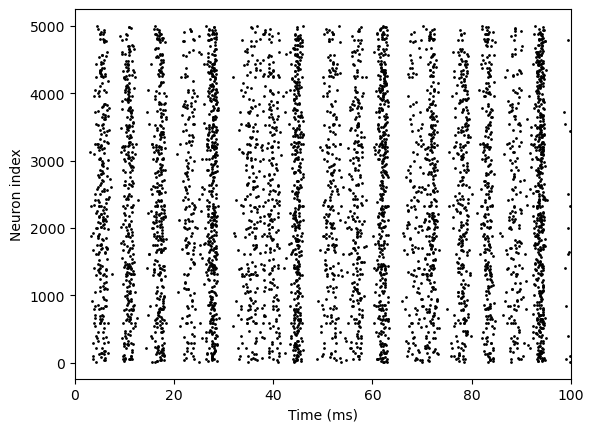

In [5]:
runner = bp.dyn.DSRunner(net, monitors=['group.spike'])
runner.run(duration)
bp.visualize.raster_plot(runner.mon.ts, runner.mon['group.spike'],
                         xlim=(0, duration), show=True)